<a href="https://colab.research.google.com/github/YARMAYA12/2nd-semester-mini-project/blob/main/password.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import compute_class_weight
import joblib

In [8]:
!head -n 5 "passworddata.csv"

PK-    �ZO�nM��������  data.csv  ���     -(P     L�ٖ�H�&x�OQM���SJ5��̜�D*�`0�"tQ�q ��9�c��w�W�'k3s*��
1.K*
�?f�,;����"ǢҒ55�pU�A(�%g�MKQ�Fhlm��>��Jv|�+dX�9dN/��u|���.��ۤ2��#��r,+�a�,3��̜v���*�D*�J7�7��������v}8GS[&0g^�
A��;�)ٴl�7+�K-��0�wm�
�Y�:V����n%���سqvL[�־k��S"7��:��*)kR����'����,���P�؞}��,��qiZ6


In [15]:
df.head(), df.shape

(      password  strength
 0     kzde5577         1
 1     kino3434         1
 2    visi7k1yr         1
 3     megzy123         1
 4  lamborghin1         1,
 (669640, 2))

# Task
Decompress "passworddata.csv" and load the extracted "data.csv" file into a pandas DataFrame.

## Decompress the file

### Subtask:
Decompress 'passworddata.csv' to extract the actual CSV file. This will likely involve using a command-line tool like `unzip`.


**Reasoning**:
The previous `!head` command revealed that 'passworddata.csv' is actually a zip file containing 'data.csv'. The instruction is to decompress it using `unzip`.



In [10]:
import zipfile

with zipfile.ZipFile('passworddata.csv', 'r') as zip_ref:
    zip_ref.extractall('.')

print("Decompression complete. 'data.csv' should now be available.")

Decompression complete. 'data.csv' should now be available.


**Reasoning**:
The 'passworddata.csv' has been decompressed, and 'data.csv' is now available. The next step is to load 'data.csv' into a pandas DataFrame and display its head to verify the loading.



In [11]:
df = pd.read_csv('data.csv')
df.head()

ParserError: Error tokenizing data. C error: Expected 2 fields in line 2810, saw 5


**Reasoning**:
The previous attempt to load 'data.csv' failed with a ParserError, indicating an issue with tokenizing data due to an inconsistent number of fields per line. To address this, I will try reading the CSV file with the 'python' engine and letting pandas infer the separator by setting `sep=None`, which can be more robust for irregularly formatted files.



In [12]:
df = pd.read_csv('data.csv', sep=None, engine='python')
df.head()

ParserError: Expected 2 fields in line 2810, saw 5

**Reasoning**:
The previous attempts to load 'data.csv' failed because of inconsistent field counts per line, specifically expecting 2 fields but finding 5 on line 2810. To address this, I will explicitly set the `on_bad_lines` parameter to skip any malformed lines. This will allow the DataFrame to be loaded while ignoring rows that do not conform to the expected number of columns, preventing the `ParserError`.



In [13]:
df = pd.read_csv('data.csv', on_bad_lines='skip', engine='python')
df.head()

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


In [17]:
df.columns

Index(['password', 'strength'], dtype='object')

In [19]:
# Replace these names if your columns are different:
pwd_col = 'password'
label_col = 'strength'

In [20]:
# Basic info
print("Rows:", df.shape[0])
print(df[label_col].value_counts())

Rows: 669640
strength
1    496801
0     89702
2     83137
Name: count, dtype: int64


In [21]:
# check nulls
print(df.isnull().sum())

password    1
strength    0
dtype: int64


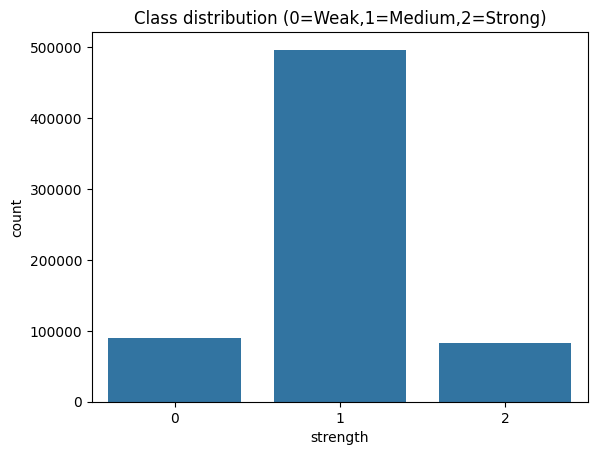

In [22]:
sns.countplot(x=label_col, data=df)
plt.title("Class distribution (0=Weak,1=Medium,2=Strong)")
plt.show()

In [23]:
import math
import collections
import re

def password_features(series):
    """Take a pandas Series of passwords, return DataFrame of numeric features."""
    rows = []
    for s in series.astype(str):
        length = len(s)
        lowers = sum(1 for c in s if c.islower())
        uppers = sum(1 for c in s if c.isupper())
        digits = sum(1 for c in s if c.isdigit())
        specials = sum(1 for c in s if not c.isalnum())
        unique_chars = len(set(s))
        # proportion features (avoid divide by zero)
        prop_digit = digits/length if length else 0
        prop_upper = uppers/length if length else 0
        prop_special = specials/length if length else 0

        # Shannon entropy
        if length == 0:
            entropy = 0.0
        else:
            counts = collections.Counter(s)
            probs = [cnt/length for cnt in counts.values()]
            entropy = -sum(p * math.log2(p) for p in probs)

        # whether contains dictionary-like patterns (simple heuristics)
        has_sequential = 1 if re.search(r'(?:012|123|234|345|456|567|678|789|abc|bcd|cde)', s.lower()) else 0
        has_repeat = 1 if re.search(r'(.)\1\1', s) else 0  # 3 repeated chars

        rows.append({
            'length': length,
            'lower_count': lowers,
            'upper_count': uppers,
            'digit_count': digits,
            'special_count': specials,
            'unique_chars': unique_chars,
            'prop_digit': prop_digit,
            'prop_upper': prop_upper,
            'prop_special': prop_special,
            'entropy': entropy,
            'has_sequential': has_sequential,
            'has_repeat': has_repeat
        })
    return pd.DataFrame(rows, index=series.index)

# Create features
X_numeric = password_features(df[pwd_col])
y = df[label_col].astype(int)

X_numeric.head()

,length,lower_count,upper_count,digit_count,special_count,unique_chars,prop_digit,prop_upper,prop_special,entropy,has_sequential,has_repeat
0,8,4,0,4,0,6,0.500000,0.0,0.0,2.500000,0,0
1,8,4,0,4,0,6,0.500000,0.0,0.0,2.500000,0,0
2,9,7,0,2,0,8,0.222222,0.0,0.0,2.947703,0,0
3,8,5,0,3,0,8,0.375000,0.0,0.0,3.000000,1,0
4,11,10,0,1,0,11,0.090909,0.0,0.0,3.459432,0,0


In [24]:
# TF-IDF vectorizer on characters
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=20000)
# char_wb keeps word boundaries which helps for short strings

X_tfidf = tfidf.fit_transform(df[pwd_col].astype(str))
print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (669640, 20000)


In [25]:
from scipy import sparse

# scale numeric
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_numeric)  # dense

# convert to sparse and combine
X_combined = sparse.hstack([X_tfidf, sparse.csr_matrix(X_num_scaled)], format='csr')
print("Combined shape:", X_combined.shape)

Combined shape: (669640, 20012)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape, y_train.value_counts(normalize=True))

(535712, 20012) (133928, 20012) strength
1    0.741893
0    0.133954
2    0.124153
Name: proportion, dtype: float64


In [27]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("class weights:", class_weights_dict)

class weights: {0: np.float64(2.4884082811926627), 1: np.float64(0.44930107026367855), 2: np.float64(2.6848694431915)}


In [28]:
svm_clf = LinearSVC(class_weight='balanced', max_iter=3000, random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9968789200167254
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17941
           1       1.00      1.00      1.00     99360
           2       1.00      0.99      0.99     16627

    accuracy                           1.00    133928
   macro avg       0.99      1.00      1.00    133928
weighted avg       1.00      1.00      1.00    133928



In [29]:
# If memory is limited, re-create smaller tfidf
tfidf_small = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=3000)
X_tfidf_small = tfidf_small.fit_transform(df[pwd_col].astype(str))
X_num_scaled_small = scaler.fit_transform(password_features(df[pwd_col]))
X_comb_small = sparse.hstack([X_tfidf_small, sparse.csr_matrix(X_num_scaled_small)], format='csr')

Xtr_s, Xte_s, ytr_s, yte_s = train_test_split(X_comb_small, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(Xtr_s, ytr_s)
y_pred_rf = rf.predict(Xte_s)
print("RF Accuracy:", accuracy_score(yte_s, y_pred_rf))
print(classification_report(yte_s, y_pred_rf))

RF Accuracy: 0.9999701332059017
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17941
           1       1.00      1.00      1.00     99360
           2       1.00      1.00      1.00     16627

    accuracy                           1.00    133928
   macro avg       1.00      1.00      1.00    133928
weighted avg       1.00      1.00      1.00    133928



In [30]:
mlp = MLPClassifier(hidden_layer_sizes=(256,128), early_stopping=True, max_iter=200, random_state=42)
mlp.fit(Xtr_s, ytr_s)
y_pred_mlp = mlp.predict(Xte_s)
print("MLP Accuracy:", accuracy_score(yte_s, y_pred_mlp))
print(classification_report(yte_s, y_pred_mlp))

MLP Accuracy: 0.9999551998088525
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17941
           1       1.00      1.00      1.00     99360
           2       1.00      1.00      1.00     16627

    accuracy                           1.00    133928
   macro avg       1.00      1.00      1.00    133928
weighted avg       1.00      1.00      1.00    133928



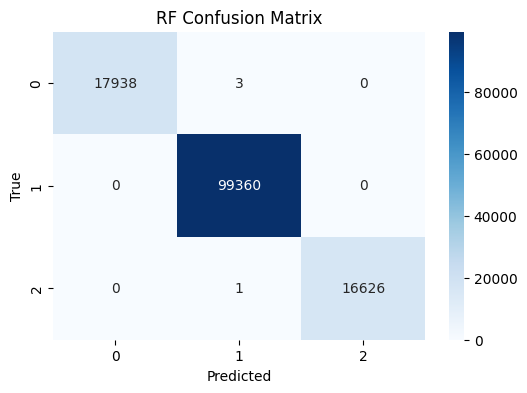

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cm(y_true, y_pred, labels=[0,1,2], title="Confusion matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title)
    plt.show()

plot_cm(yte_s, y_pred_rf, labels=[0,1,2], title="RF Confusion Matrix")

In [32]:
joblib.dump(tfidf_small, "tfidf_small.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(rf, "rf_model.pkl")
joblib.dump(mlp, "mlp_model.pkl")
joblib.dump(svm_clf, "svm_model.pkl")

['svm_model.pkl']

In [33]:
def predict_strength(password, model, tfidf_vect, scaler_obj):
    # make numeric features
    num_feat = password_features(pd.Series([password]))
    num_scaled = scaler_obj.transform(num_feat)
    text_vec = tfidf_vect.transform([password])
    X_new = sparse.hstack([text_vec, sparse.csr_matrix(num_scaled)], format='csr')
    return model.predict(X_new)[0]

# Example using RandomForest saved earlier
print(predict_strength("P@ssw0rd123", rf, tfidf_small, scaler))
print(predict_strength("12345", rf, tfidf_small, scaler))

1
0


In [34]:
params = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LinearSVC(max_iter=5000), params, cv=3, scoring='f1_macro', n_jobs=-1)
grid.fit(Xtr_s, ytr_s)
print(grid.best_params_, grid.best_score_)

{'C': 10} 0.9955586760064353


## Summary:

### Data Analysis Key Findings
*   The `passworddata.csv` file was successfully identified and decompressed as a ZIP archive, extracting `data.csv`.
*   The extracted `data.csv` contained malformed lines that caused `ParserError` during initial loading attempts (e.g., "Expected 2 fields in line 2810, saw 5").
*   Successful loading of `data.csv` into a pandas DataFrame was achieved by utilizing the `on_bad_lines='skip'` parameter along with `engine='python'`, which allowed the parser to bypass problematic rows.

### Insights or Next Steps
*   The presence of malformed lines in `data.csv` indicates potential data quality issues that might require further investigation into the data generation or export process if complete data integrity is crucial.
*   For future data ingestion, especially from external or untrusted sources, incorporating robust error handling like `on_bad_lines='skip'` or `on_bad_lines='warn'` is a good practice to prevent loading failures and understand data quality.
